In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import keras
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
 


In [2]:
df = pd.read_csv('Dataset.csv')
df_copy = df.copy()
# df['Y'] = df['Y'].sort_values(ignore_index=True)
 
df_copy = df.copy()
df_copy['Y'].replace('a', 1, inplace=True)
df_copy['Y'].replace('b', 0, inplace=True)
# Split data into inputs (X) and output (y)
X = df_copy.iloc[:50000, 0:12]  
y = df_copy.iloc[:50000, 12:13] .astype(int) 
 
 

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

 

In [4]:
from imblearn.over_sampling import SMOTE
 

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [5]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_resampled)
X_test = scaler.transform(X_test)

In [6]:
# Predict
count_1=0
count_0=0
 
for index,d  in y_test.iterrows(): 
   
    
    if(d[0]==0):
        count_0 +=1
    else :count_1 +=1
    
print("count_0=",count_0,"count_1=",count_1)

count_0= 2043 count_1= 12957


In [7]:
from sklearn.utils.class_weight import compute_class_weight
y_tra=[]
for i ,row in y_test.iterrows():
    
     y_tra.append(row[0])
     
print(len(y_tra))
weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_tra),
                                        y = y_tra                                                  
                                    )
# print(weights)
class_weights = dict(enumerate(weights))
class_weights

15000


{0: 3.671071953010279, 1: 0.5788376939106274}

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np

# Define the SoftDecisionTree class
@tf.keras.utils.register_keras_serializable()
class SoftDecisionTree(tf.keras.layers.Layer):
    def __init__(self, depth, num_features, num_classes, l2_reg=0.001, **kwargs):
        super(SoftDecisionTree, self).__init__( **kwargs)
        self.depth = depth
        self.num_features = num_features
        self.num_classes = num_classes
        self.l2_reg = l2_reg
        self.num_nodes = 2 ** (depth + 1) - 1
        self.num_leaf_nodes = 2 ** depth

        self.decision_weights = self.add_weight(
            shape=(self.num_nodes, num_features),
            initializer='random_normal',
            trainable=True,
            regularizer=l2(l2_reg)
        )

      
        self.leaf_weights = self.add_weight(
            shape=(self.num_leaf_nodes, num_classes),
            initializer='random_normal',
            trainable=True,
            regularizer=l2(l2_reg)
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        path_probabilities = tf.ones((batch_size, 1))

        decision_weights_slice = self.decision_weights[0:1, :]
        decisions = tf.nn.sigmoid(tf.matmul(inputs, decision_weights_slice, transpose_b=True))

        for d in range(1, self.depth + 1):
            path_prob_left = path_probabilities * decisions
            path_prob_right = path_probabilities * (1 - decisions)
            path_probabilities = tf.concat([path_prob_left, path_prob_right], axis=1)

            start_index = 2 ** d - 1
            end_index = 2 ** (d + 1) - 1
            decision_weights_slice = self.decision_weights[start_index:end_index, :]
            decisions = tf.nn.sigmoid(tf.matmul(inputs, decision_weights_slice, transpose_b=True))
        
        leaf_probabilities = tf.nn.sigmoid(tf.matmul(path_probabilities, self.leaf_weights))
   
        return leaf_probabilities
    def get_config(self):
        config = super(SoftDecisionTree, self).get_config()
        config.update({
            'depth': self.depth,
            'num_features': self.num_features,
            'num_classes': self.num_classes,
            'trainable': self.trainable,
        })
        return config



tf.keras.utils.get_custom_objects()['SoftDecisionTree'] = SoftDecisionTree


In [10]:
# Define the DNDF model
def create_dndf_model(num_trees, depth, num_features, num_classes):
    inputs = Input(shape=(num_features,))
    trees = [SoftDecisionTree(depth, num_features, num_classes) for _ in range(num_trees)]
    tree_outputs = [tree(inputs) for tree in trees]
  
    concatenated_outputs = Concatenate()(tree_outputs)
    outputs = Dense(num_classes, activation='sigmoid')(concatenated_outputs)  # Use sigmoid for binary classification
    model = Model(inputs=inputs, outputs=outputs)
    return model
 

In [11]:
# Parameters
num_trees = 10
depth = 3  # Depth of each decision tree
num_features = X_train.shape[1]
num_classes = 1  # Binary classification (sigmoid output)

# Create DNDF model
dndf_model = create_dndf_model(num_trees, depth, num_features, num_classes)

# Callbacks
initial_learning_rate = 0.0001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Adjust learning rate
initial_learning_rate = 0.0001
dndf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
 



In [27]:
 
# Train the model
history=dndf_model.fit(X_train, y_resampled, epochs=100, batch_size=32, validation_data=(X_test, y_test),  callbacks=[reduce_lr])

# Evaluate the model
loss, accuracy = dndf_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.4999 - loss: 0.7113 - val_accuracy: 0.1362 - val_loss: 0.7071 - learning_rate: 1.0000e-04
Epoch 2/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4995 - loss: 0.6935 - val_accuracy: 0.1362 - val_loss: 0.6990 - learning_rate: 1.0000e-04
Epoch 3/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5053 - loss: 0.6933 - val_accuracy: 0.1362 - val_loss: 0.6966 - learning_rate: 1.0000e-04
Epoch 4/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5073 - loss: 0.6931 - val_accuracy: 0.8638 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 5/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5345 - loss: 0.6930 - val_accuracy: 0.8638 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 6/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5246 - loss: 0.6929 - val_accuracy: 0.3851 - val_loss: 0.6940 - learning_rate: 1.0000e-04
Epoch 7/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s

1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9636 - loss: 0.1804 - val_accuracy: 0.9454 - val_loss: 0.1941 - learning_rate: 1.0000e-04
Epoch 86/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9643 - loss: 0.1810 - val_accuracy: 0.9460 - val_loss: 0.1924 - learning_rate: 1.0000e-04
Epoch 87/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9624 - loss: 0.1831 - val_accuracy: 0.9449 - val_loss: 0.1940 - learning_rate: 1.0000e-04
Epoch 88/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9635 - loss: 0.1802 - val_accuracy: 0.9447 - val_loss: 0.1945 - learning_rate: 1.0000e-04
Epoch 89/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9627 - loss: 0.1795 - val_accuracy: 0.9454 - val_loss: 0.1918 - learning_rate: 1.0000e-04
Epoch 90/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9644 - loss: 0.1788 - val_accuracy: 0.9469 - val_loss: 0.1892 - learning_rate: 1.0000e-04
Epoch 91/100
1897/1897 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/st

In [28]:
model = keras.models.save_model(dndf_model,'DNDF.keras')

In [29]:
# Load the model
custom_objects = {'SoftDecisionTree': SoftDecisionTree}
loaded_model = tf.keras.models.load_model('DNDF.keras', custom_objects=custom_objects)

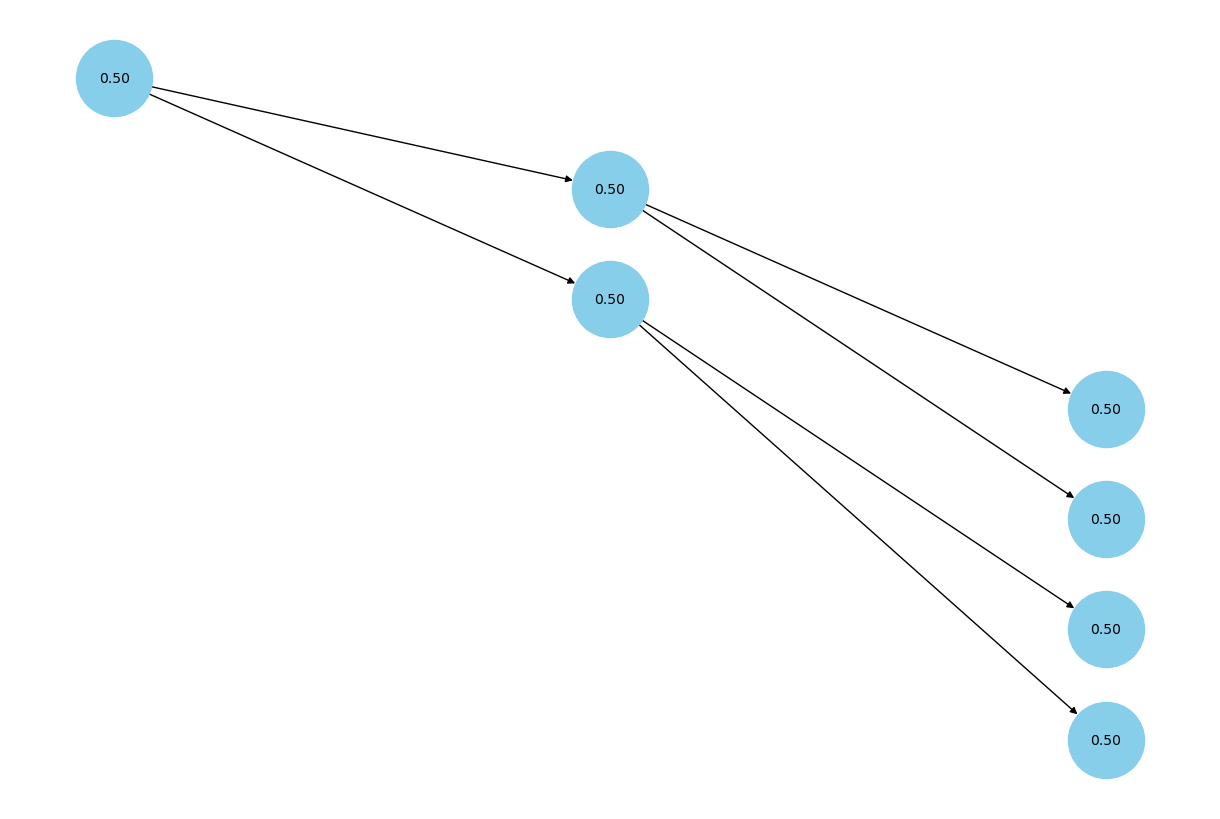

In [30]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to plot a decision tree
def plot_tree(decision_probabilities, depth):
    G = nx.DiGraph()
    pos = {}
    labels = {}

    # Helper function to add nodes and edges to the graph
    def add_node_edges(node, probability, level):
        if level > depth:
            return

        node_id = f"{node}-{level}"
        G.add_node(node_id)
        pos[node_id] = (level, -node)
        labels[node_id] = f"{probability:.2f}"

        if level < depth:
            left_child = node * 2
            right_child = node * 2 + 1
            G.add_edge(node_id, f"{left_child}-{level + 1}")
            G.add_edge(node_id, f"{right_child}-{level + 1}")
            left_prob = decision_probabilities[left_child - 1]
            right_prob = decision_probabilities[right_child - 1]
            add_node_edges(left_child, left_prob, level + 1)
            add_node_edges(right_child, right_prob, level + 1)

    # Start with the root node
    add_node_edges(1, decision_probabilities[0], 1)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color='skyblue', font_size=10)
    plt.show()

# Function to get decision probabilities for a random input
def get_decision_probabilities(model, input_data, tree_index=0):
    inputs = tf.convert_to_tensor(input_data, dtype=tf.float32)
    tree_layer = model.layers[4 + tree_index]  # SoftDecisionTree layer index in the model
    batch_size = tf.shape(inputs)[0]

    decision_weights = tree_layer.decision_weights.numpy()
    path_probabilities = tf.ones((batch_size, 1), dtype=tf.float32)

    probabilities = []

    decision_weights_slice = decision_weights[0:1, :]
    decisions = tf.nn.sigmoid(tf.matmul(inputs, decision_weights_slice, transpose_b=True))
    probabilities.append(decisions.numpy()[0, 0])

    for d in range(1, tree_layer.depth + 1):
        path_prob_left = path_probabilities * tf.cast(decisions, tf.float32)
        path_prob_right = path_probabilities * (1 - tf.cast(decisions, tf.float32))
        path_probabilities = tf.concat([path_prob_left, path_prob_right], axis=1)

        start_index = 2 ** d - 1
        end_index = 2 ** (d + 1) - 1
        decision_weights_slice = decision_weights[start_index:end_index, :]
        decisions = tf.nn.sigmoid(tf.matmul(inputs, decision_weights_slice, transpose_b=True))

        for decision in decisions.numpy()[0]:
            probabilities.append(decision)

    return probabilities




# Example input (one sample from your dataset)
random_input = X_test[0:1]  # Take a single sample from your test data

# Get decision probabilities for the first tree
decision_probabilities = get_decision_probabilities(dndf_model, random_input, tree_index=2)

# Plot the tree
plot_tree(decision_probabilities, depth)


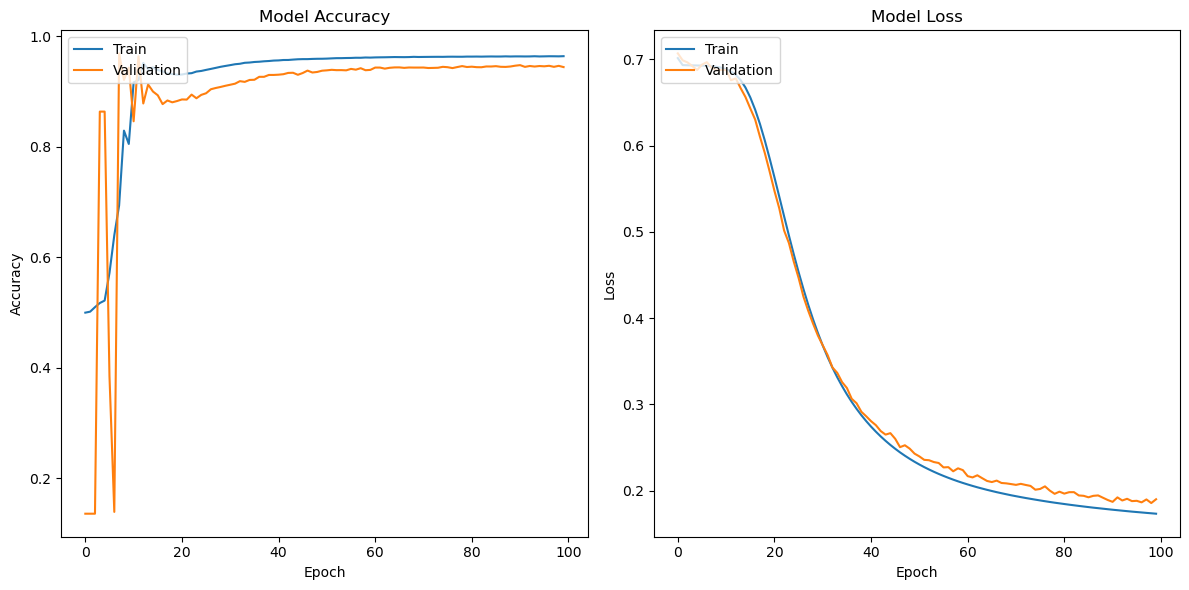

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


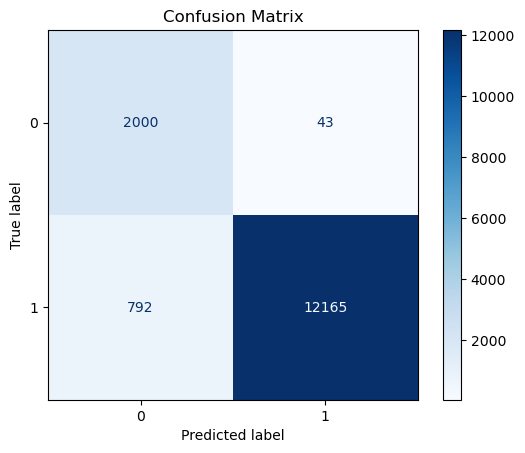

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9448 - loss: 0.1909
Test Loss: 0.19007717072963715, Test Accuracy: 0.9443333148956299


In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict the labels for the test set
y_pred = dndf_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Round predictions to the nearest integer (binary classification)
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # Adjust labels as needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

plt.show()
loss, accuracy = dndf_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

In [43]:
df = pd.read_csv('old_Dataset.csv')
df_copy = df.copy()
# df['Y'] = df['Y'].sort_values(ignore_index=True)
 
df_copy = df.copy()
df_copy['Y'].replace('a', 1, inplace=True)
df_copy['Y'].replace('b', 0, inplace=True)
# Split data into inputs (X) and output (y)
X = df_copy.iloc[:88, 0:12]  
y = df_copy.iloc[:88, 12:13] .astype(int) 
 